In [ ]:
# =====================================
# Cell 1: Create Project Structure (GitHub/Local/Colab friendly)
# =====================================



import os, re, glob, json, random
from datetime import datetime

# Set project root folder

project_path = os.getenv('PROJECT_PATH', '.')
top_level_dirs = [
    'data/raw',
    'data/processed',
    'notebooks',
    'models/saved_models',
    'models/checkpoints',
    'results/figures',
    'results/metrics',
    'results/attributions',
    'configs',
    'runs'
]
for d in top_level_dirs:
    os.makedirs(os.path.join(project_path, d), exist_ok=True)

def _next_version(base_dir: str) -> int:
    """Return next integer version (v001, v002, …) under base_dir."""
    os.makedirs(base_dir, exist_ok=True)
    existing = glob.glob(os.path.join(base_dir, r'v[0-9][0-9][0-9]*'))
    nums = []
    for p in existing:
        m = re.search(r'v(\d+)', os.path.basename(p))
        if m:
            nums.append(int(m.group(1)))
    return (max(nums) + 1) if nums else 1

def start_run(experiment: str, config: dict, root: str = project_path):
    """
    Create a new versioned run folder:
      runs/<experiment>/vXYZ_YYYYMMDD-HHMMSS/{figures,metrics,models,logs,configs}
    Save the config, and return (version_int, run_dir).
    """
    base = os.path.join(root, 'runs', experiment)
    ver = _next_version(base)
    run_dir = os.path.join(base, f'v{ver:03d}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

    #  Per-run subfolders
    subdirs = ['figures', 'metrics', 'models', 'logs', 'configs','attributions']
    for sub in subdirs:
        os.makedirs(os.path.join(run_dir, sub), exist_ok=True)

    # Save config files
    with open(os.path.join(run_dir, 'configs', 'config.json'), 'w') as f:
        json.dump(config, f, indent=2)
    with open(os.path.join(run_dir, 'configs', 'config.txt'), 'w') as f:
        for k, v in config.items():
            f.write(f"{k}: {v}\n")

    # Add README
    with open(os.path.join(run_dir, 'README.md'), 'w') as f:
        f.write(f"# Experiment: {experiment} (v{ver:03d})\n")
        f.write(f"Created: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write("## Notes:\n- \n")

    # Paths dictionary for later saving
    paths = {name: os.path.join(run_dir, name) for name in subdirs}
    paths.update({
        "results_figures": os.path.join(project_path, "results/figures"),
        "results_metrics": os.path.join(project_path, "results/metrics"),
        "results_attributions": os.path.join(project_path, "results/attributions"),
        "project_root": project_path,
    })

    print(f'▶ New run: {experiment} v{ver:03d}\n  {run_dir}')
    return ver, run_dir , paths


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell 3: Import Libraries
#!pip install -q imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

# === Core Libraries ===
import os
import json
import glob
import re
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap



# === Data Collection ===
import yfinance as yf

# === Machine Learning ===
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, matthews_corrcoef, balanced_accuracy_score,
    precision_recall_curve )
from sklearn.model_selection import train_test_split

# === Deep Learning ===
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard
)

# === Reproducibility ===
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = '42'


In [ ]:
CONFIG = {
    "experiment": "RQ1_RQ2",
    "horizon": 7,
    "window": 40,
    "val_size": 0.10,       # 10% validation
    "test_size": 0.20,      # 20% test
    "lstm1": 128,
    "lstm2": 64,
    "dropout": 0.05,
    "lr": 1e-3,
    "batch_size": 32,
    "epochs": 50,

}

VER, RUN_DIR, paths = start_run(CONFIG["experiment"], CONFIG)


▶ New run: RQ1_RQ2 v002
  /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ1_RQ2/v002_20250907-073439


## Importing Data

## 1. Download and Prepare NVDA Stock Data

Automatically downloads from Yahoo Finance and saves to `data/raw/`.


In [ ]:
def get_nvda_stock_data():
    """
    Fetch Nvidia'S historical stock data from Yahoo Finance.

    Returns:
        pd.DataFrame: DataFrame containing adjusted close prices indexed by date.
    """
    # Fetch data for Nvidia (NVDA) from Yahoo Finance
    ticker = "NVDA"
    start_date = "2015-02-02"
    end_date = "2025-05-01"
    nvda = yf.download(ticker, start=start_date, end=end_date, auto_adjust = False)
    nvda.columns = nvda.columns.get_level_values(0)
    nvda_data = nvda.rename(columns={"Adj Close":"AdjClose"})
    return nvda_data


# get nvidia stock data
nvda_data = get_nvda_stock_data()

# Save to existing folder
nvda_data.to_csv(os.path.join(project_path,'data/raw/nvda_stock_data.csv'))


[*********************100%***********************]  1 of 1 completed


## Exploratory Data Analysis & Preprocessing

In [ ]:
nvda_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2577 entries, 2015-02-02 to 2025-04-30
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AdjClose  2577 non-null   float64
 1   Close     2577 non-null   float64
 2   High      2577 non-null   float64
 3   Low       2577 non-null   float64
 4   Open      2577 non-null   float64
 5   Volume    2577 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 140.9 KB


In [ ]:
nvda_data.shape


(2577, 6)

In [ ]:
nvda_data.describe()

Price,AdjClose,Close,High,Low,Open,Volume
count,2577.000000,2577.000000,2577.000000,2577.000000,2577.000000,2.577000e+03
mean,24.101116,24.133789,24.591379,23.634800,24.139256,4.641495e+08
std,36.447139,36.445757,37.169331,35.676176,36.494109,2.522240e+08
min,0.467325,0.482750,0.488250,0.473500,0.481250,5.244800e+07
25%,3.684062,3.710750,3.785750,3.637500,3.695500,3.009040e+08
50%,6.805059,6.859500,6.987500,6.784750,6.891500,4.119680e+08
75%,23.265320,23.285999,23.879999,22.770000,23.320000,5.574420e+08
max,149.405869,149.429993,153.130005,147.820007,153.029999,3.692928e+09


In [ ]:
nvda_data.isnull().sum()

,0
Price,
AdjClose,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [ ]:
# Display the first few rows of data
nvda_data.head(10)

Price,AdjClose,Close,High,Low,Open,Volume
Date,,,,,,
2015-02-02,0.470827,0.49050,0.49250,0.47350,0.48300,259604000
2015-02-03,0.482586,0.50275,0.50325,0.49150,0.49400,183468000
2015-02-04,0.483786,0.50400,0.50975,0.49975,0.50125,181516000
2015-02-05,0.491704,0.51225,0.51250,0.50400,0.50450,140448000
2015-02-06,0.489545,0.51000,0.51775,0.50775,0.51175,210524000
2015-02-09,0.489065,0.50950,0.51100,0.50375,0.50700,273944000
2015-02-10,0.502744,0.52375,0.52400,0.50775,0.51000,226204000
2015-02-11,0.499384,0.52025,0.52500,0.51675,0.52500,320832000
2015-02-12,0.535140,0.55750,0.56250,0.54675,0.55000,676904000


In [ ]:
# Display the last few rows of data
nvda_data.tail(10)

Price,AdjClose,Close,High,Low,Open,Volume
Date,,,,,,
2025-04-16,104.482742,104.489998,106.790001,100.449997,104.550003,397016900
2025-04-17,101.482948,101.489998,104.470001,100.050003,104.449997,292517500
2025-04-21,96.903275,96.910004,99.440002,95.040001,98.769997,288501100
2025-04-22,98.883133,98.889999,99.809998,97.279999,98.779999,241004800
2025-04-23,102.702866,102.709999,104.800003,102.019997,104.519997,247526000
2025-04-24,106.422607,106.430000,106.540001,103.110001,103.480003,220815000
2025-04-25,111.002296,111.010002,111.919998,105.730003,106.849998,251064700
2025-04-28,108.722450,108.730003,110.370003,106.019997,109.690002,207708500
2025-04-29,109.012428,109.019997,110.199997,107.440002,107.669998,170444300


The plot provides a visual representation of the trend in **NVDA's** closing prices over time. The **x-axis** represents the **dates**, while the **y-axis** represents the **closing prices in USD**. This visualization helps in understanding the historical price movements of **NVDA** stock.

In [ ]:
plt.figure(figsize=(16,8))
plt.title('NVIDIA Stock Close Price (2015-2025)')
plt.plot(nvda_data['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)',fontsize=18)
fig_path = os.path.join(paths["results_figures"], "nvda_close_price_timeseries.png")
plt.savefig(fig_path, dpi=300)
plt.close()

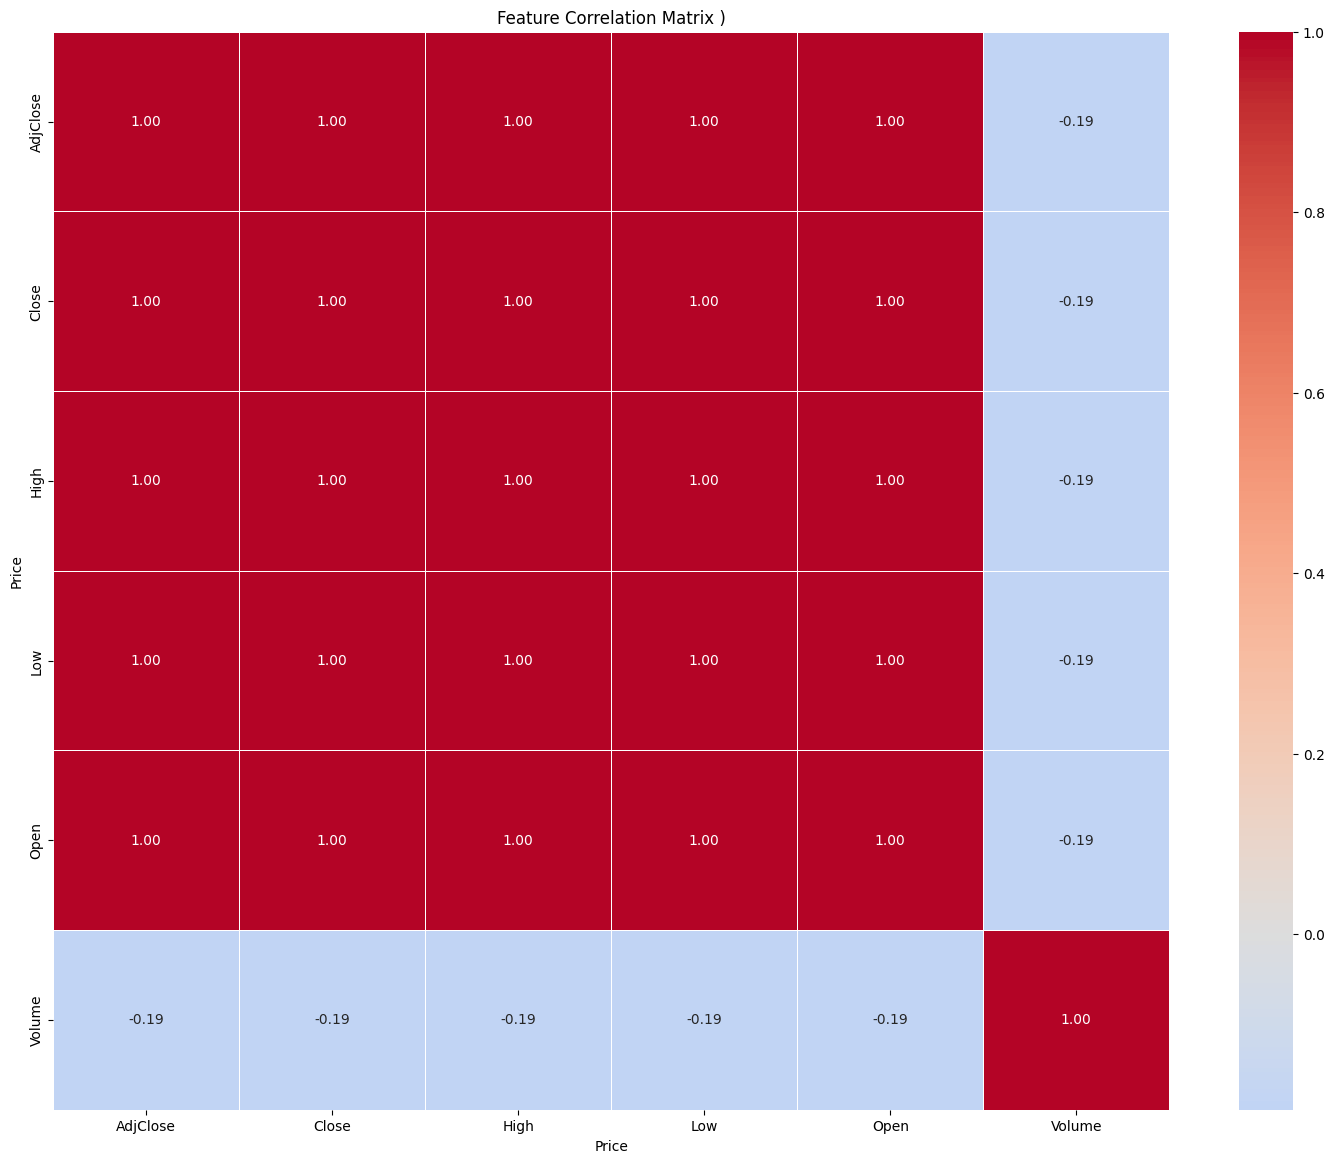

In [ ]:

# Compute correlation matrix
corr = nvda_data[nvda_data.select_dtypes(include=[np.number]).columns.tolist()].dropna().corr()

# Plot the heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Feature Correlation Matrix )")
corr_path = os.path.join(paths["results_figures"], "feature_corr_heatmap.png")
plt.savefig(corr_path, dpi=300)
plt.close()

## 2. Feature Engineering
Creates regime labels and standard technical features.


In [ ]:
H = int(CONFIG["horizon"])

# Next-day log return target
nvda_data['log_ret_next'] = np.log(nvda_data['Close'].shift(-H) / nvda_data['Close'])

# Regime label
nvda_data['RegimeLabel'] = (nvda_data['log_ret_next'] > 0).astype(int)



# Remove rows with NaN in RegimeLabel or log_ret_next
nvda_data.dropna(subset=['log_ret_next', 'RegimeLabel'], inplace=True)


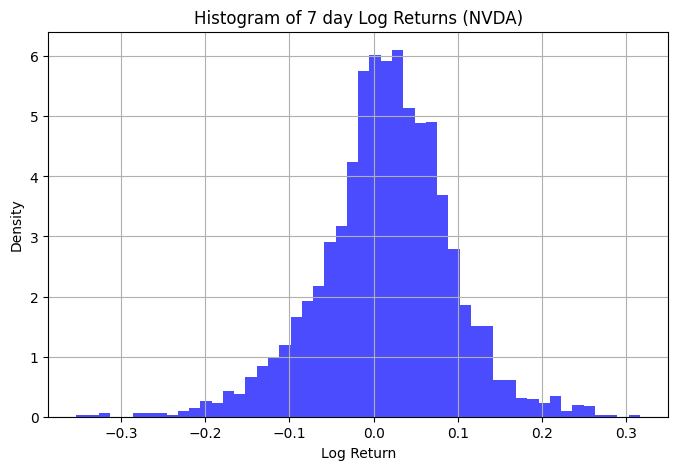

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(nvda_data['log_ret_next'], bins=50, density=True, alpha=0.7, color='blue')
plt.title('Histogram of 7 day Log Returns (NVDA)')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.grid(True)
hist_path = os.path.join(paths["results_figures"], "hist_7day_log_returns.png")
plt.savefig(hist_path, dpi=300)
plt.close()


In [ ]:


# Exponential Moving Averages and their difference

nvda_data['ema_delta'] = (
    nvda_data['Close'].ewm(span=9,  adjust=False).mean()
  - nvda_data['Close'].ewm(span=21, adjust=False).mean() )

# Simple Moving Averages and their difference
nvda_data['sma_delta'] = (
    nvda_data['Close'].rolling(window=5).mean()
  - nvda_data['Close'].rolling(window=10).mean() )

# Rolling volatility
nvda_data['rolling_vol_20d'] = (
    np.log(nvda_data['Close'] / nvda_data['Close'].shift(1)).rolling(window=20).std())

# RSI (14-day)
delta = nvda_data['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / (avg_loss + 1e-9)
nvda_data['rsi_14'] = 100 - (100 / (1 + rs))


# OBV (On-Balance Volume)
obv = [0]
for i in range(1, len(nvda_data)):
    if nvda_data['Close'].iloc[i] > nvda_data['Close'].iloc[i - 1]:
        obv.append(obv[-1] + nvda_data['Volume'].iloc[i])
    elif nvda_data['Close'].iloc[i] < nvda_data['Close'].iloc[i - 1]:
        obv.append(obv[-1] - nvda_data['Volume'].iloc[i])
    else:
        obv.append(obv[-1])
nvda_data['obv'] = obv


# Bollinger Bands (corrected bandwidth)
bb_mean = nvda_data['Close'].rolling(window=20).mean()
bb_std = nvda_data['Close'].rolling(window=20).std()
nvda_data['bollinger_bandwidth'] = ((bb_mean + 2*bb_std) - (bb_mean - 2*bb_std)) / bb_mean


# 1‐day lagged log return
nvda_data['return_lag_1'] = (
    np.log(nvda_data['Close'] / nvda_data['Close'].shift(1)).shift(1))


# Clean
nvda_data.dropna(inplace=True)
nvda_data.drop(columns=['Open','High','Low','Volume','AdjClose'], inplace=True)




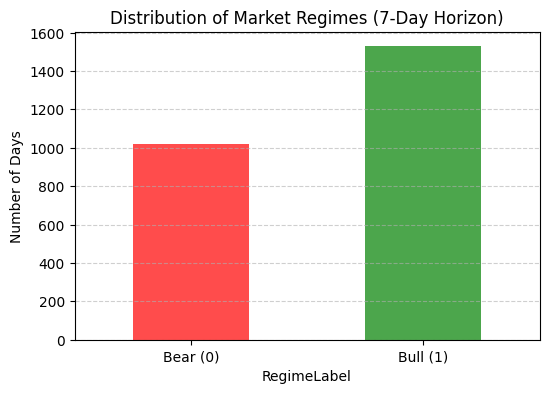

In [ ]:
# ----------------------------
# Regime Distribution Plot
# ----------------------------

counts = nvda_data['RegimeLabel'].value_counts().sort_index()

plt.figure(figsize=(6,4))
counts.plot(kind='bar', color=['red','green'], alpha=0.7)
plt.xticks([0,1], ['Bear (0)','Bull (1)'], rotation=0)
plt.title('Distribution of Market Regimes (7-Day Horizon)')
plt.ylabel('Number of Days')
plt.grid(axis='y', linestyle='--', alpha=0.6)
regime_path = os.path.join(paths["results_figures"], "regime_distribution.png")
plt.savefig(regime_path, dpi=300)
plt.close()

In [ ]:
nvda_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2550 entries, 2015-03-03 to 2025-04-21
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Close                2550 non-null   float64
 1   log_ret_next         2550 non-null   float64
 2   RegimeLabel          2550 non-null   int64  
 3   ema_delta            2550 non-null   float64
 4   sma_delta            2550 non-null   float64
 5   rolling_vol_20d      2550 non-null   float64
 6   rsi_14               2550 non-null   float64
 7   obv                  2550 non-null   int64  
 8   bollinger_bandwidth  2550 non-null   float64
 9   return_lag_1         2550 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 219.1 KB


## 4. Sequence Construction and Data Splitting


In [ ]:
# === Features & target===
X = nvda_data.drop(columns=['RegimeLabel', 'log_ret_next','Close'])
y = nvda_data['log_ret_next'].astype(float)

def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(window_size, len(X)):
        Xs.append(X[i-window_size:i])  # (window, features)
        ys.append(y[i])                # target at i
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X.values, y.values, CONFIG["window"])

# === Unified Train–Val–Test Split  ===

VAL_SIZE  = float(CONFIG["val_size"])   # e.g., 0.10
TEST_SIZE = float(CONFIG["test_size"])  # e.g., 0.20
save_path = os.path.join(project_path, 'data/processed')
os.makedirs(save_path, exist_ok=True)
bounds_file = f"{save_path}/split_bounds.npz"

def _compute_bounds(n):
    n_test  = int(TEST_SIZE * n)
    n_val   = int(VAL_SIZE  * n)
    n_train = n - n_val - n_test
    assert n_train > 0 and n_test > 0, "Check val/test sizes."
    train_end = n_train
    val_end   = n_train + n_val
    return train_end, val_end

# compute & save once
train_end, val_end = _compute_bounds(len(X_seq))
np.savez(bounds_file, train_end=train_end, val_end=val_end, n=len(X_seq))

# apply split
X_train, X_val, X_test = X_seq[:train_end], X_seq[train_end:val_end], X_seq[val_end:]
y_train, y_val, y_test = y_seq[:train_end], y_seq[train_end:val_end], y_seq[val_end:]

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)
print("X_test: ", X_test.shape,  "y_test: ", y_test.shape)



X_train: (1757, 40, 7) y_train: (1757,)
X_val:   (251, 40, 7) y_val:   (251,)
X_test:  (502, 40, 7) y_test:  (502,)


## 4. Feature and Target Scaling


In [ ]:
# classification from reg output:
y_seq_cls = (y_seq > 0).astype(int)
y_train_cls, y_val_cls, y_test_cls = y_seq_cls[:train_end], y_seq_cls[train_end:val_end], y_seq_cls[val_end:]


# Feature scaling
feat_scaler = StandardScaler()
n_samp, n_steps, n_feats = X_train.shape

# Fit scaler on training features
X_train_scaled = feat_scaler.fit_transform(X_train.reshape(-1, n_feats)).reshape(n_samp, n_steps, n_feats)
X_val_scaled   = feat_scaler.transform(X_val.reshape(-1, n_feats)).reshape(X_val.shape[0], n_steps, n_feats)
X_test_scaled  = feat_scaler.transform(X_test.reshape(-1, n_feats)).reshape(X_test.shape[0], n_steps, n_feats)

# Save scaler for reproducibility
joblib.dump(feat_scaler, os.path.join(paths["configs"], "feature_scaler_standard.pkl"))
print("Feature StandardScaler fitted and saved.")


# Target scaling
tgt_scaler = StandardScaler()
y_train_scaled = tgt_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled   = tgt_scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled  = tgt_scaler.transform(y_test.reshape(-1, 1)).flatten()



Feature StandardScaler fitted and saved.


## 5. LSTM Model Definition and Training


In [ ]:
# 5) Define your LSTM
model_reg = Sequential([
    Input(shape=(n_steps, n_feats)),
    LSTM(CONFIG["lstm1"], return_sequences=True),
    Dropout(CONFIG["dropout"]),
    LSTM(CONFIG["lstm2"], return_sequences=False),
    Dropout(CONFIG["dropout"]),
    Dense(32, activation='relu'),
    Dense(1)
])

model_reg.compile(optimizer=keras.optimizers.Adam(CONFIG["lr"]),
                  loss='mse', metrics=['mae'])
model_reg.summary()


# 6) Callbacks
ckpt_best = os.path.join(paths["models"], "best_val_model.keras")
csv_log   = os.path.join(paths["logs"], "train_log.csv")
es  = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
mc  = ModelCheckpoint(ckpt_best, monitor='val_loss', save_best_only=True, verbose=1)
csv = CSVLogger(csv_log)


callbacks = [es, mc, csv]


# ── Step 4: Train  ──────────────────────────────────────────
history_reg = model_reg.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=CONFIG["epochs"],
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    callbacks=callbacks,
    verbose=2
)

# === Step 7: Save Final Model ===
final_model_path = os.path.join(paths["models"], "final_model.keras")
model_reg.save(final_model_path)
print("Saved best:", ckpt_best)
print(f"Saved Final: {final_model_path}")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 40, 128)        │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,153 (473.25 KB)

 Trainable params: 121,153 (473.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50

Epoch 1: val_loss improved from inf to 1.53072, saving model to /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ1_RQ2/v002_20250907-073439/models/best_val_model.keras
55/55 - 11s - 197ms/step - loss: 1.0480 - mae: 0.7611 - val_loss: 1.5307 - val_mae: 0.9862
Epoch 2/50

Epoch 2: val_loss improved from 1.53072 to 1.52574, saving model to /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ1_RQ2/v002_20250907-073439/models/best_val_model.keras
55/55 - 4s - 76ms/step - loss: 1.0249 - mae: 0.7539 - val_loss: 1.5257 - val_mae: 0.9790
Epoch 3/50

Epoch 3: val_loss improved from 1.52574 to 1.48905, saving model to /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ1_RQ2/v002_20250907-073439/models/best_val_model.keras
55/55 - 5s - 88ms/step - loss: 0.9829 - mae: 0.7394 - val_loss: 1.4891 - val_mae: 0.9676
Epoch 4/50

Epoch 4: val_loss did not improve from 1.48905
55/55 - 6s - 101ms/step - loss: 0.9563 - mae: 0.7264 - val_loss: 1.5295 - val_mae: 0.9884
Epoch 5/50

Epoch 5: val_los

## 6. Evaluation and Export



Predictions CSV saved to: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ1_RQ2/v002_20250907-073439/metrics/test_predictions.csv
  y_true   y_pred
0.064506 0.014455
0.039442 0.017062
0.027717 0.019183
0.049115 0.020449
0.061994 0.021613

 === Model Evaluation Metrics (Test) ===
  MSE: 0.0073
 RMSE: 0.08543
  MAE: 0.06772
Regression metrics saved to: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ1_RQ2/v002_20250907-073439/metrics/nvda_rnn_regression_metrics.json
 Loss curve saved to: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ1_RQ2/v002_20250907-073439/figures/loss_curve.png


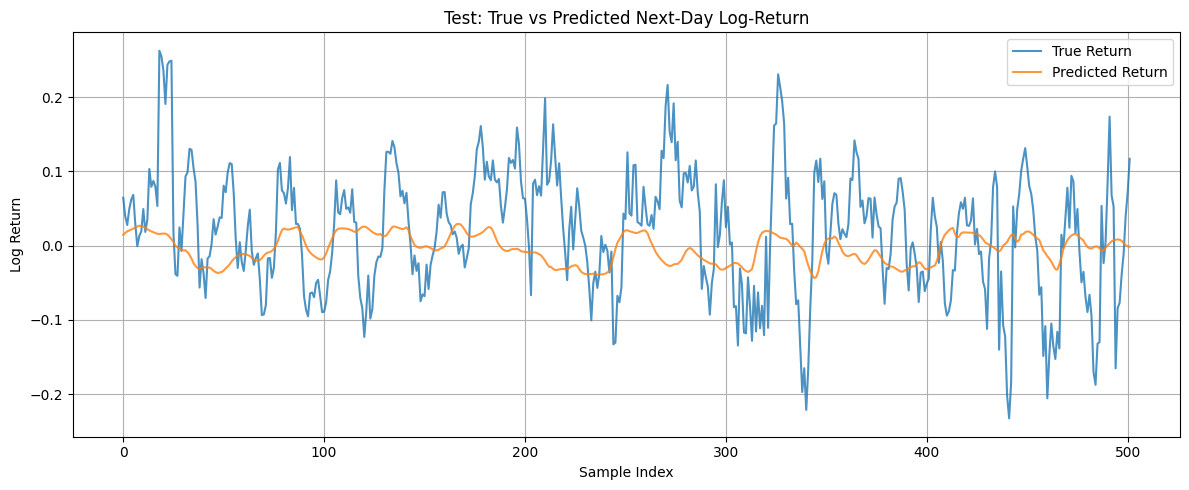

Return prediction plot saved to: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ1_RQ2/v002_20250907-073439/figures/pred_vs_true_returns.png


In [ ]:
# ===== 1) Get Predictions =====
y_pred_scaled = model_reg.predict(X_test_scaled, verbose=0).flatten()
y_pred = tgt_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = y_test

# Save predictions CSV
preds_df = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})
preds_path = os.path.join(paths["metrics"], "test_predictions.csv")
preds_df.to_csv(preds_path, index=False)
print(f"\nPredictions CSV saved to: {preds_path}")
print(preds_df.head(5).to_string(index=False))

# ===== 2) Compute & Save Regression Metrics =====
mse  = mean_squared_error(y_true, y_pred)
rmse = float(np.sqrt(mse))
mae  = mean_absolute_error(y_true, y_pred)

metrics_dict = {"MSE": round(mse, 5), "RMSE": round(rmse, 5), "MAE": round(mae, 5)}

print("\n === Model Evaluation Metrics (Test) ===")
for k, v in metrics_dict.items():
    print(f"{k:>5}: {v}")

metrics_path = os.path.join(paths["metrics"], "nvda_rnn_regression_metrics.json")
with open(metrics_path, "w") as f:
    json.dump(metrics_dict, f, indent=4)
print(f"Regression metrics saved to: {metrics_path}")

# ===== 3) Loss Curve =====
plt.figure(figsize=(10, 4))
plt.plot(history_reg.history['loss'], label='Training Loss (MSE)', linewidth=2)
if 'val_loss' in history_reg.history:
    plt.plot(history_reg.history['val_loss'], label='Validation Loss (MSE)', linewidth=2)
plt.title('Training Loss (MSE) Over Epochs'); plt.xlabel('Epoch'); plt.ylabel('Loss (MSE)')
plt.legend(); plt.grid(True); plt.tight_layout()

loss_fig_path = os.path.join(paths["figures"], "loss_curve.png")
plt.savefig(loss_fig_path, dpi=300)
plt.close()
print(f" Loss curve saved to: {loss_fig_path}")

# ===== 4) Predictions vs True (returns) =====
plt.figure(figsize=(12, 5))
plt.plot(y_true, label='True Return', alpha=0.8)
plt.plot(y_pred, label='Predicted Return', alpha=0.8)
plt.title('Test: True vs Predicted Next-Day Log-Return')
plt.xlabel('Sample Index'); plt.ylabel('Log Return')
plt.legend(); plt.grid(True); plt.tight_layout()

pred_fig_path = os.path.join(paths["figures"], "pred_vs_true_returns.png")
plt.savefig(pred_fig_path, dpi=300)
plt.close()
print(f"Return prediction plot saved to: {pred_fig_path}")



In [ ]:
# ===== Residuals Distribution =====
residuals = y_true - y_pred

plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=40, kde=True, color="steelblue")
plt.axvline(0, color="red", linestyle="--", label="Zero Error")
plt.title("Distribution of Prediction Errors (Residuals)")
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()

err_hist_path = os.path.join(paths["figures"], "residuals_distribution.png")
plt.savefig(err_hist_path, dpi=300); plt.close()
print(f"Residuals histogram saved to: {err_hist_path}")




Residuals histogram saved to: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ1_RQ2/v002_20250907-073439/figures/residuals_distribution.png


In [ ]:
# === 11. (RQ2) Balanced Classification Metrics via Oversampling (train only) ===

# Create classification labels
y_train_cls = (y_train > 0).astype(int)
y_val_cls   = (y_val > 0).astype(int)
y_test_cls  = (y_test > 0).astype(int)

# Oversample only training set for classification metrics
X_train_flat = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_cls_bal = ros.fit_resample(X_train_flat, y_train_cls)
X_train_bal = X_train_bal.reshape(-1, X_train_scaled.shape[1], X_train_scaled.shape[2])
print("Original train bull/bear counts:", np.bincount(y_train_cls))
print("Balanced train bull/bear counts:", np.bincount(y_train_cls_bal))

# Predict using regression model on balanced training set
y_pred_train_scaled = model_reg.predict(X_train_bal, verbose=0).flatten()
y_pred_train = tgt_scaler.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).flatten()
predicted_labels_train = (y_pred_train > 0).astype(int)

# Classification metrics on balanced training set (for fair comparison)
print("\n=== Train Classification Metrics (Balanced) ===")
print(classification_report(y_train_cls_bal, predicted_labels_train, target_names=['Bear(0)', 'Bull(1)'], digits=4))

# Save confusion matrix + report for balanced train set
cm_train = confusion_matrix(y_train_cls_bal, predicted_labels_train)
report_train = classification_report(y_train_cls_bal, predicted_labels_train, target_names=['Bear(0)','Bull(1)'], zero_division=0)
cm_txt_path_train = os.path.join(paths["metrics"], "confusion_matrix_balanced_train.txt")
with open(cm_txt_path_train, "w") as f:
    f.write("Confusion Matrix (rows=true, cols=pred):\n")
    f.write(str(cm_train) + "\n\n")
    f.write("Classification Report (Balanced Train):\n")
    f.write(report_train)
print(f"Confusion matrix + report (balanced train) saved to: {cm_txt_path_train}")

# Confusion matrix figure (balanced train)
plt.figure(figsize=(5, 4))
plt.imshow(cm_train, cmap='Blues')
plt.title('Confusion Matrix (Balanced Train)'); plt.xlabel('Predicted'); plt.ylabel('True')
plt.xticks([0,1], ['Bear(0)','Bull(1)']); plt.yticks([0,1], ['Bear(0)','Bull(1)'])
for (i, j), val in np.ndenumerate(cm_train):
    plt.text(j, i, int(val), ha='center', va='center')
plt.colorbar(); plt.tight_layout()
cm_fig_path_train = os.path.join(paths["figures"], "confusion_matrix_balanced_train.png")
plt.savefig(cm_fig_path_train, dpi=300)
plt.close()
print(f"Confusion matrix figure (balanced train) saved to: {cm_fig_path_train}")



Original train bull/bear counts: [ 694 1063]
Balanced train bull/bear counts: [1063 1063]

=== Train Classification Metrics (Balanced) ===
              precision    recall  f1-score   support

     Bear(0)     0.7544    0.1214    0.2091      1063
     Bull(1)     0.5223    0.9605    0.6766      1063

    accuracy                         0.5409      2126
   macro avg     0.6383    0.5409    0.4428      2126
weighted avg     0.6383    0.5409    0.4428      2126

Confusion matrix + report (balanced train) saved to: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ1_RQ2/v002_20250907-073439/metrics/confusion_matrix_balanced_train.txt
Confusion matrix figure (balanced train) saved to: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ1_RQ2/v002_20250907-073439/figures/confusion_matrix_balanced_train.png



 === Classification Metrics (from Log-Return Predictions) ===
 Accuracy: 0.5657
Precision: 0.6892
   Recall: 0.5066
       F1: 0.584
  ROC_AUC: 0.6058
 Classification metrics saved to: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ1_RQ2/v002_20250907-073439/metrics/nvda_rnn_classification_metrics.json

 Confusion Matrix (rows=true, cols=pred):
 [[131  69]
 [149 153]]

 Classification Report:
               precision    recall  f1-score   support

     Bear(0)       0.47      0.66      0.55       200
     Bull(1)       0.69      0.51      0.58       302

    accuracy                           0.57       502
   macro avg       0.58      0.58      0.56       502
weighted avg       0.60      0.57      0.57       502

Confusion matrix + report saved to: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ1_RQ2/v002_20250907-073439/metrics/confusion_matrix.txt


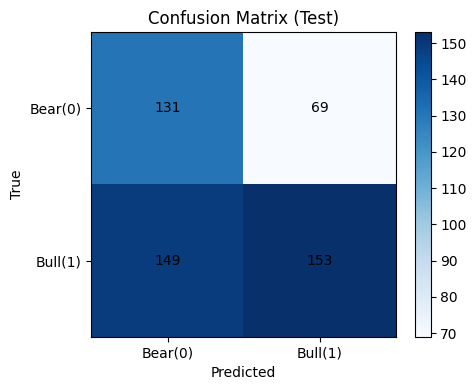

 Confusion matrix figure saved to: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ1_RQ2/v002_20250907-073439/figures/confusion_matrix.png


In [ ]:

# ===== 4) Classification from Predicted Log-Returns =====
predicted_labels = (y_pred > 0).astype(int)
true_labels = (y_true > 0).astype(int)

acc = accuracy_score(true_labels, predicted_labels)
prec = precision_score(true_labels, predicted_labels)
rec = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
try:
    roc_auc = roc_auc_score(true_labels, y_pred)
except ValueError:
    roc_auc = float('nan')


classification_metrics = {
    "Accuracy": round(acc, 4),
    "Precision": round(prec, 4),
    "Recall": round(rec, 4),
    "F1": round(f1, 4),
    "ROC_AUC": None if np.isnan(roc_auc) else round(roc_auc, 4)
}

print("\n === Classification Metrics (from Log-Return Predictions) ===")
for k, v in classification_metrics.items():
    print(f"{k:>9}: {v}")

cls_metrics_path = os.path.join(paths["metrics"], "nvda_rnn_classification_metrics.json")
with open(cls_metrics_path, "w") as f:
    json.dump(classification_metrics, f, indent=4)
print(f" Classification metrics saved to: {cls_metrics_path}")


# Confusion matrix + report (print to console and save)
cm = confusion_matrix(true_labels, predicted_labels)
report = classification_report(true_labels, predicted_labels, target_names=['Bear(0)','Bull(1)'], zero_division=0)
print("\n Confusion Matrix (rows=true, cols=pred):\n", cm)
print("\n Classification Report:\n", report)

cm_txt_path = os.path.join(paths["metrics"], "confusion_matrix.txt")
with open(cm_txt_path, "w") as f:
    f.write("Confusion Matrix (rows=true, cols=pred):\n")
    f.write(str(cm) + "\n\n")
    f.write("Classification Report:\n")
    f.write(report)
print(f"Confusion matrix + report saved to: {cm_txt_path}")

# Confusion matrix figure
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix (Test)'); plt.xlabel('Predicted'); plt.ylabel('True')
plt.xticks([0,1], ['Bear(0)','Bull(1)']); plt.yticks([0,1], ['Bear(0)','Bull(1)'])
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, int(val), ha='center', va='center')
plt.colorbar(); plt.tight_layout()
cm_fig_path = os.path.join(paths["figures"], "confusion_matrix.png")
plt.savefig(cm_fig_path, dpi=300)
plt.close()
print(f" Confusion matrix figure saved to: {cm_fig_path}")




In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(true_labels, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], color="red", linestyle="--", label="Random Guess")
plt.title("ROC Curve – Regime Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

roc_path = os.path.join(paths["figures"], "roc_curve.png")
plt.savefig(roc_path, dpi=300)
print(f"ROC curve saved to: {roc_path}")
plt.close()

precisions, recalls, thresholds = precision_recall_curve(true_labels, y_pred)

plt.figure(figsize=(7,6))
plt.plot(recalls, precisions, lw=2, color="green")
plt.title("Precision–Recall Curve – Regime Classification")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.tight_layout()

pr_path = os.path.join(paths["figures"], "precision_recall_curve.png")
plt.savefig(pr_path, dpi=300);
print(f"Precision–Recall curve saved to: {pr_path}")
plt.close()

print("Train set regime distribution:", np.bincount(y_train_cls))
print("Val set regime distribution:", np.bincount(y_val_cls))
print("Test set regime distribution:", np.bincount(y_test_cls))



ROC curve saved to: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ1_RQ2/v002_20250907-073439/figures/roc_curve.png
Precision–Recall curve saved to: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ1_RQ2/v002_20250907-073439/figures/precision_recall_curve.png
Train set regime distribution: [ 694 1063]
Val set regime distribution: [112 139]
Test set regime distribution: [200 302]


In [ ]:
# ===== 7) Save final model
final_model_path = os.path.join(paths["models"], 'nvda_rnn_regression_final.keras')
model_reg.save(final_model_path)
print(f"Final model saved to: {final_model_path}")
print(f" Best-by-val checkpoint: {ckpt_best}")

Final model saved to: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ1_RQ2/v002_20250907-073439/models/nvda_rnn_regression_final.keras
 Best-by-val checkpoint: /content/drive/MyDrive/nvda_rnn_forecasting/runs/RQ1_RQ2/v002_20250907-073439/models/best_val_model.keras


In [ ]:
# === EXPORT: single source of truth for RQ3/RQ5 ===
import os, json, joblib, shutil, hashlib, numpy as np, pandas as pd
ART = os.path.join(project_path, "artifacts")
os.makedirs(ART, exist_ok=True)

# 1) Dates aligned to sequences (skip look-back rows)
seq_index = nvda_data.index[CONFIG["window"]:]
test_dates = pd.to_datetime(seq_index[val_end:])

# 2) Save arrays
np.save(os.path.join(ART, "X_train_scaled.npy"), X_train_scaled.astype(np.float32))
np.save(os.path.join(ART, "X_val_scaled.npy"),   X_val_scaled.astype(np.float32))
np.save(os.path.join(ART, "X_test_scaled.npy"),  X_test_scaled.astype(np.float32))
np.save(os.path.join(ART, "y_test.npy"),         y_test)


n_feats = X_test_scaled.shape[2]
X_test_unscaled = feat_scaler.inverse_transform(X_test_scaled.reshape(-1, n_feats)).reshape(X_test_scaled.shape)
np.save(os.path.join(ART, "X_test_unscaled.npy"), X_test_unscaled.astype(np.float32))

# 3) Regimes CSV (truth + prediction)
reg_true = (y_test > 0).astype(int)
reg_pred = (y_pred > 0).astype(int)
reg_df = pd.DataFrame({
    "date": test_dates,
    "y_test": y_test,
    "pred": y_pred,
    "regime_true": reg_true,
    "regime_pred": reg_pred
})
reg_df.to_csv(os.path.join(ART, "test_regimes.csv"), index=False)

# 4) Meta + fixed SHAP background indices (no leakage)
feature_names = list(X.columns)
lookback = int(X_train.shape[1])
B = X_train_scaled[:min(1024, len(X_train_scaled))]
bg_idx = list(range(len(B)))  # we use the *first* 1024 train windows as background
np.save(os.path.join(ART, "shap_background.npy"), B.astype(np.float32))
json.dump({"features": feature_names, "lookback": lookback, "bg_idx": bg_idx},
          open(os.path.join(ART, "meta.json"), "w"))

# 5) Save the exact model & scalers
# Use the best-by-validation checkpoint;
BASELINE = os.path.join(ART, "baseline_lstm.keras")
shutil.copy(ckpt_best, BASELINE)
joblib.dump(feat_scaler, os.path.join(ART, "feature_scaler_standard.pkl"))
joblib.dump(tgt_scaler,  os.path.join(ART, "target_scaler_standard.pkl"))

# 6) Minimal manifest (shapes + hashes) for verification in RQ3/RQ5
def _sha256(p):
    h = hashlib.sha256()
    with open(p, "rb") as f:
        for chunk in iter(lambda: f.read(524288), b""): h.update(chunk)
    return h.hexdigest()

manifest = {
    "config": {
        "horizon": CONFIG["horizon"],
        "window":  lookback,
        "n_features": len(feature_names),
    },
    "files": {
        "baseline_model": {"path": BASELINE, "sha256": _sha256(BASELINE)},
        "X_test_scaled":  {"path": "X_test_scaled.npy",  "shape": list(X_test_scaled.shape)},
        "y_test":         {"path": "y_test.npy",         "shape": list(y_test.shape)},
        "test_regimes":   {"path": "test_regimes.csv",   "rows": int(len(reg_df))},
        "shap_background":{"path": "shap_background.npy","shape": list(B.shape)},
        "feature_scaler": {"path": "feature_scaler_standard.pkl"},
    },
    "features": feature_names
}
json.dump(manifest, open(os.path.join(ART, "manifest.json"), "w"), indent=2)
print(" Exported artifacts & manifest to:", ART)


 Exported artifacts & manifest to: /content/drive/MyDrive/nvda_rnn_forecasting/artifacts
